In [ ]:
import ROOT as r
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from Event import Event

In [ ]:
'''
Returns the time vs. x and time vs. y data from the pixel_hits. The ATAR is made up of sheets that contain alternating horizontal or vertical strips with npixels_per_plane.
If npixels_per_plane were 100, for instance, 100036 would represent plate 1, 36 / 100 in x, 100161 would represent plate 2, 61 / 100 in y, etc. The output for each of 
x and y is an n x 2 matrix, where the first column contains the times corresponding to the coordinate values in the second column.
Also extract the z (plane #) vs. time data. The third element of the tuples contained in this list and the x and y lists will contain corresponding colors to represent
when particles have decayed.
'''
def process_event(tree, event_index):
    #Get the specified entry so we can extract data from it.
    tree.GetEntry(event_index)

    #Store pixel hits for the entry printed above in which a pion didn't decay at rest.
    pixel_times = tree.pixel_time
    pixel_hits = tree.pixel_hits
    pixel_pdg = tree.pixel_pdg
    pixel_edep = tree.pixel_edep
    
    #Initialize lists for storing color (for labeling data points according to decay product), t, x, y, z, energy, and energy per plane using the Event class.
    npixels_per_plane = 100
    event = Event()
    
    #Extract x vs. t, y vs. t, and z vs. t data. Also add indexed color coding to represent different particles.
    for i in range(pixel_hits.size()):
        plane = int(np.floor((pixel_hits[i] - 1 - 100_000) / npixels_per_plane))

        cur_val = (pixel_hits[i] - 1) % npixels_per_plane
        cur_time = pixel_times[i]

        if pixel_pdg[i] == 211:
            cur_color = "r"     # +Pion
        elif pixel_pdg[i] == -11:
            cur_color = "b"     # Positron
        elif pixel_pdg[i] == 11:
            cur_color = "g"     # Electron
        elif pixel_pdg[i] == -13:
            cur_color = "y"     # +Muon
        elif pixel_pdg[i] == 13:
            cur_color = "p"     # -Muon

        event.c_data.append(cur_color)
        event.t_data.append(cur_time)

        if(plane % 2 == 0):
            event.x_data.append(cur_val)
            event.y_data.append(np.nan)
        else:
            event.y_data.append(cur_val)
            event.x_data.append(np.nan)

        event.z_data.append(plane)
        event.E_data.append(pixel_edep[i])
        #Keep track of sum of energies deposited in each plane.
        event.E_per_plane[plane] += pixel_edep[i]

    #Keep track of maximum energy deposited per plane in this event.
    event.max_E = max(event.E_per_plane)

    #Keep track of the gap time if there is one.
    event.gap_time = 0

    return event

In [ ]:
#Show some useful parameters describing our event.
def display_event(event):
    print("Length of c_data: " + str(len(event.t_data)))
    print("Length of t_data: " + str(len(event.t_data)))
    print("Length of x_data: " + str(len(event.x_data)))
    print("Length of y_data: " + str(len(event.y_data)))
    print("Length of z_data: " + str(len(event.z_data)))
    print("Length of E_data: " + str(len(event.E_data)))
    print("Length of E_per_plane: " + str(len(event.E_per_plane)))
    print("c_data: " + str(event.c_data))
    print("x_data: " + str(event.x_data))
    print("E_data: " + str(event.E_data))

In [ ]:
#For each color in a list of color labels for different particles, plot the corresponding data.
def plot_with_color_legend(x_coords, y_coords, colors):
    for color in ["r", "b", "g", "y", "p"]:
        #Include only points of the current color / particle type each loop. This makes it easier to configure the legend.
        curpoints = []

        for i in range(len(colors)):
            if colors[i] == color:
                curpoints.append((x_coords[i], y_coords[i], colors[i]))
        
        #Only plot if the current particle decay type was present in the data.
        if len(curpoints) != 0:
            if color == "r":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Pion")
            elif color == "b":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Positron")
            elif color == "g":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Electron")
            elif color == "y":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Antimuon")
            elif color == "p":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Muon")


#Plot x vs. t, y vs. t, z vs. t, and E vs. z data from our event. The graphs will show the color-coding system used to represent different particles.
#Display 0 to num_planes on plots including the z variable.
def plot_event(event, num_planes):

    plt.figure(figsize = (25, 6))

    plt.subplot(1,4,1)

    plot_with_color_legend(event.z_data, event.x_data, event.c_data)
    plt.title("x vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("x (pix)")
    plt.legend()
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,2)
    plot_with_color_legend(event.z_data, event.y_data, event.c_data)
    plt.title("y vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("y (pix)")
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,3)
    plot_with_color_legend(event.t_data, event.z_data, event.c_data)
    plt.title("z vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("z (plane number)")
    plt.ylim(0, num_planes)

    plt.subplot(1,4,4)

    plt.scatter(event.z_data, event.E_data, 10, label = "e_dep")
    plt.scatter(range(50), event.E_per_plane, 10, "black", label = "e_dep per plane")
    plt.title("ATAR Energy Deposition Per Plane vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("Energy (MeV / plane)")
    plt.legend()
    #plt.xlim(0, num_planes)

    plt.subplots_adjust(left = 0.1,
                        bottom = 0.1, 
                        right = 0.9, 
                        top = 0.9, 
                        wspace = 0.5, 
                        hspace = 0.4)

In [88]:
#Use cuts to select the events we want from the tree. Returns an integer list of the indices of the events that we want from the tree.
#is_event_DAR: Value of 0 = decays in flight, 1 = decays at rest, 2 = all data used.
#num_events:  Controls how many events we want to select.
def select_events(tree, is_event_DAR, num_events):
    #Apply logical cut to select whether we want DARs and to exclude empty data. n stores the number of entries that satisfy this cut.
    if is_event_DAR == 0:
        cut = "!pion_dar && Sum$(pixel_edep) > 0"
    elif is_event_DAR == 1:
        cut = "pion_dar && Sum$(pixel_edep) > 0"
    else:
        cut = "Sum$(pixel_edep) > 0"
    n = tree.Draw("Entry$", cut, "goff")
    
    #Get all indices that satisfy the cut.
    events = []
    for i in range(n):
        events.append(tree.GetV1()[i])

    selected_events = events[0:num_events]
    print("Indices of selected events: " + str(selected_events))

    return [int(i) for i in selected_events]


#Combines the functions we created above to give a visualization of events with the specified condition(s).
#is_event_DAR: Value of 0 = decays in flight, 1 = decays at rest, 2 = all data used.
#display_text_output = True / False controls whether we should have text info / not have text info displayed.
#display_plots = True / False controls whether event data is plotted or not.
#num_events allows us to plot multiple events with the specified conditions from the tree.
def event_visualization(tree, is_event_DAR, display_text_output, display_plots, num_events):
    
    #Get num_events indices for events that satisfy DAR / DIF criteria.
    events = select_events(tree, is_event_DAR, num_events)

    #Use max edep per plane as a heuristic to distinguish between DIFs and DARs.
    max_Es = []

    #For each of the event indices specified, process the corresponding event and display useful output if we want, then plot it.
    for i in range(len(events)):
        e = process_event(tree, events[i])

        if display_text_output:
            display_event(e)
        
        if display_plots:
            plot_event(e, 50)

        max_Es.append(e.max_E)
    
    return max_Es

In [89]:
#Compare the maximum energy deposition of decays in flight and decays at rest. Show mean, median, and standard deviation for both sets of maximum energies, then plot them in
#histogram form. One should notice that the DARs have a higher median energy deposited, though the means may be closer due to large outliers present in some DIF data.
def compare_max_edep(max_Es_DIF, max_Es_DAR):
    max_Es_DIF_mean = np.mean(max_Es_DIF)
    max_Es_DIF_median = np.median(max_Es_DIF)
    max_Es_DIF_std = np.std(max_Es_DIF)

    max_Es_DAR_mean = np.mean(max_Es_DAR)
    max_Es_DAR_median = np.median(max_Es_DAR)
    max_Es_DAR_std = np.std(max_Es_DAR)

    print("\nmax_Es_DIF_mean: " + str(max_Es_DIF_mean))
    print("max_Es_DIF_median: " + str(max_Es_DIF_median))
    print("max_Es_DIF_std: " + str(max_Es_DIF_std))

    print("\nmax_Es_DAR_mean: " + str(max_Es_DAR_mean))
    print("max_Es_DAR_median: " + str(max_Es_DAR_median))
    print("max_Es_DAR_std: " + str(max_Es_DAR_std))


    plt.figure(figsize = (20, 6))

    plt.subplot(1,2,1)
    plt.hist(max_Es_DIF, 20, color = "blue")
    plt.title("Max Energy by Group for Decays in Flight")
    plt.xlabel("Max Energy by Group (MeV)")
    plt.ylabel("Count")

    plt.subplot(1,2,2)
    plt.hist(max_Es_DAR, 20, color = "orange")
    plt.title("Max Energy by Group for Decays at Rest")
    plt.xlabel("Max Energy by Group (MeV)")
    plt.ylabel("Count")

#TODO: Look into gap times as possible way of distinguishing between DIFs and DARs.
# def compare_gap_times():
    

Indices of selected events: [66.0, 102.0, 115.0, 117.0, 163.0, 166.0, 209.0, 308.0, 311.0, 318.0, 375.0, 437.0, 451.0, 601.0, 647.0, 654.0, 766.0, 811.0, 981.0, 1071.0, 1154.0, 1199.0, 1223.0, 1232.0, 1259.0, 1364.0, 1474.0, 1481.0, 1581.0, 1592.0, 1596.0, 1605.0, 1634.0, 1704.0, 1718.0, 2098.0, 2109.0, 2161.0, 2170.0, 2285.0, 2376.0, 2405.0, 2435.0, 2436.0, 2493.0, 2543.0, 2778.0, 2804.0, 2930.0, 2991.0, 3140.0, 3166.0, 3181.0, 3192.0, 3197.0, 3236.0, 3456.0, 3543.0, 3592.0, 3604.0, 3695.0, 3727.0, 3767.0, 3893.0, 3955.0, 4002.0, 4021.0, 4046.0, 4140.0, 4226.0, 4251.0, 4253.0, 4345.0, 4393.0, 4426.0, 4443.0, 4465.0, 4508.0, 4529.0, 4569.0, 4659.0, 4673.0, 4680.0, 4771.0, 4784.0, 4950.0, 5082.0, 5087.0, 5108.0, 5253.0, 5309.0, 5354.0, 5370.0, 5415.0, 5484.0, 5492.0, 5530.0, 5604.0, 5628.0, 5640.0]
Indices of selected events: [0.0, 1.0, 3.0, 4.0, 5.0, 7.0, 11.0, 12.0, 13.0, 14.0, 17.0, 18.0, 21.0, 22.0, 24.0, 25.0, 28.0, 29.0, 31.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 43.0, 44.0, 45.0, 

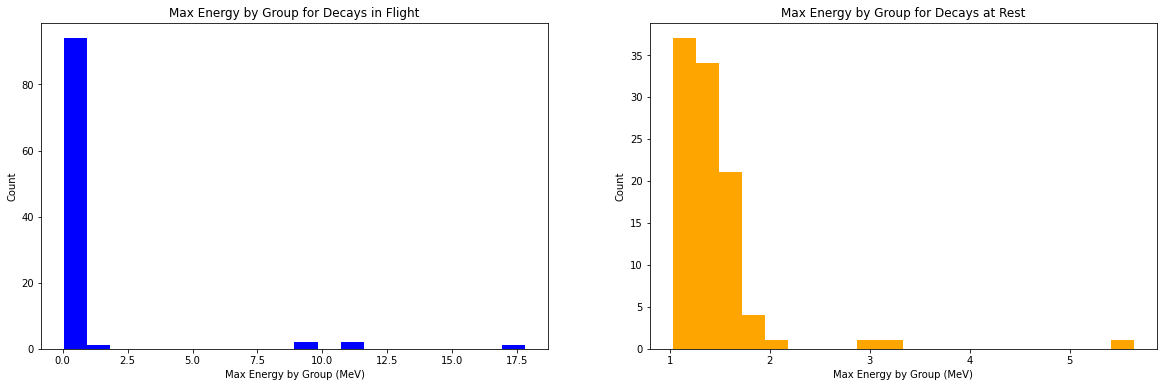

In [90]:
#Explore pion --> e data.
PiEfile = r.TFile("pienux_out_stripped.root")
PiEtree = PiEfile.Get("atar")
# print([x.GetName() for x in tree.GetListOfBranches()])
# print("\n")

max_Es_DIF = event_visualization(PiEtree, 0, False, False, 100)
max_Es_DAR = event_visualization(PiEtree, 1, False, False, 100)

compare_max_edep(max_Es_DIF, max_Es_DAR)

Indices of selected events: [66.0, 102.0, 115.0]


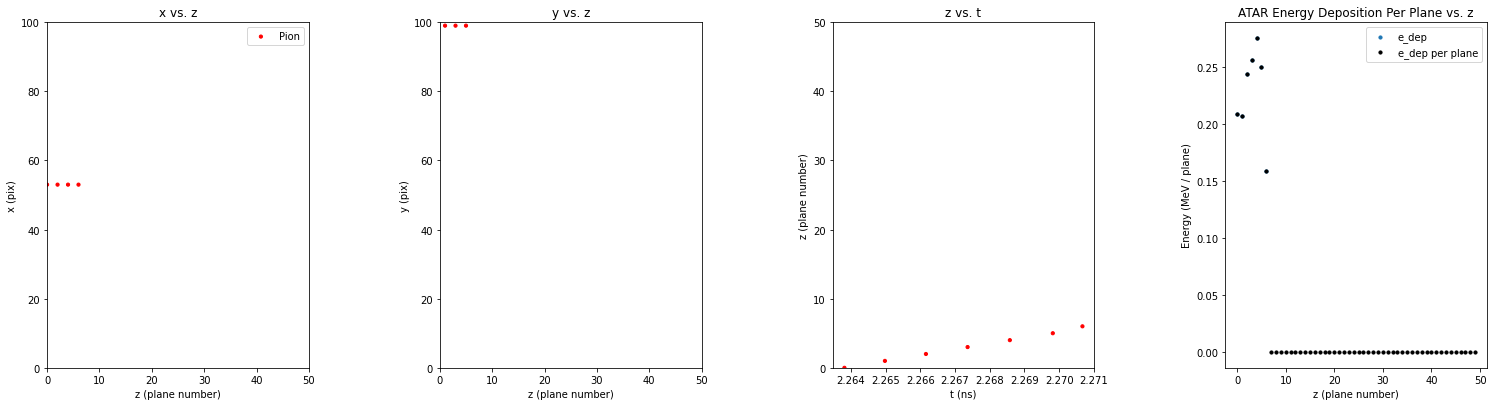

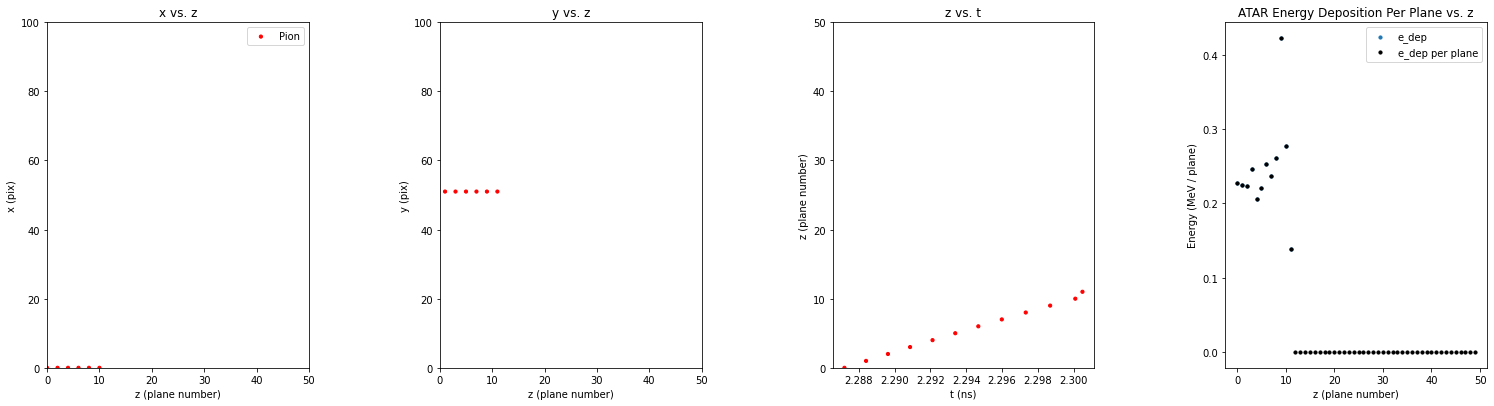

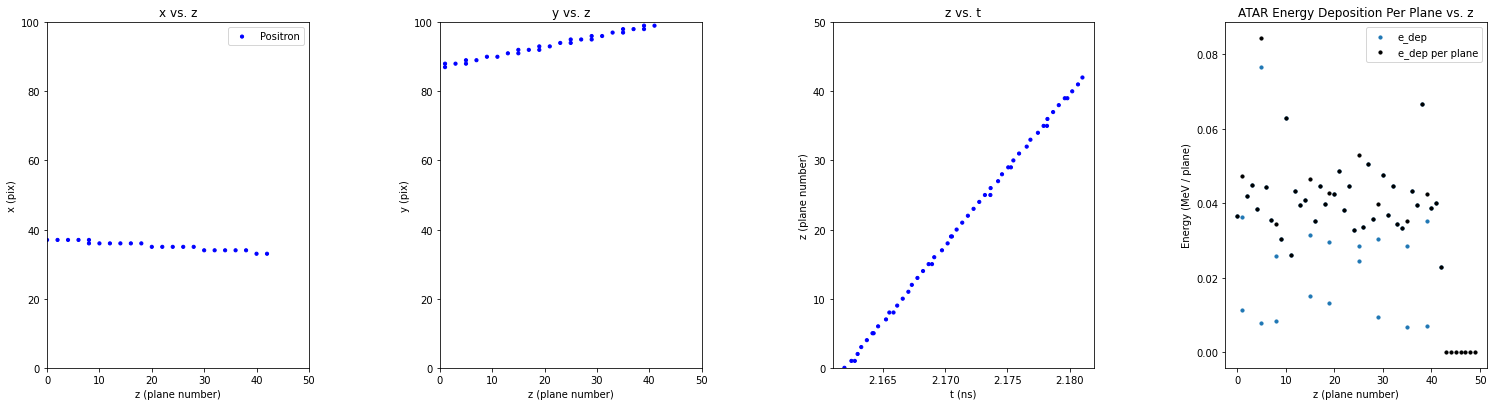

In [91]:
#Just look at plots for the pion --> e data.
max_Es = event_visualization(PiEtree, 0, False, True, 3)

Indices of selected events: [5.0, 126.0, 183.0]


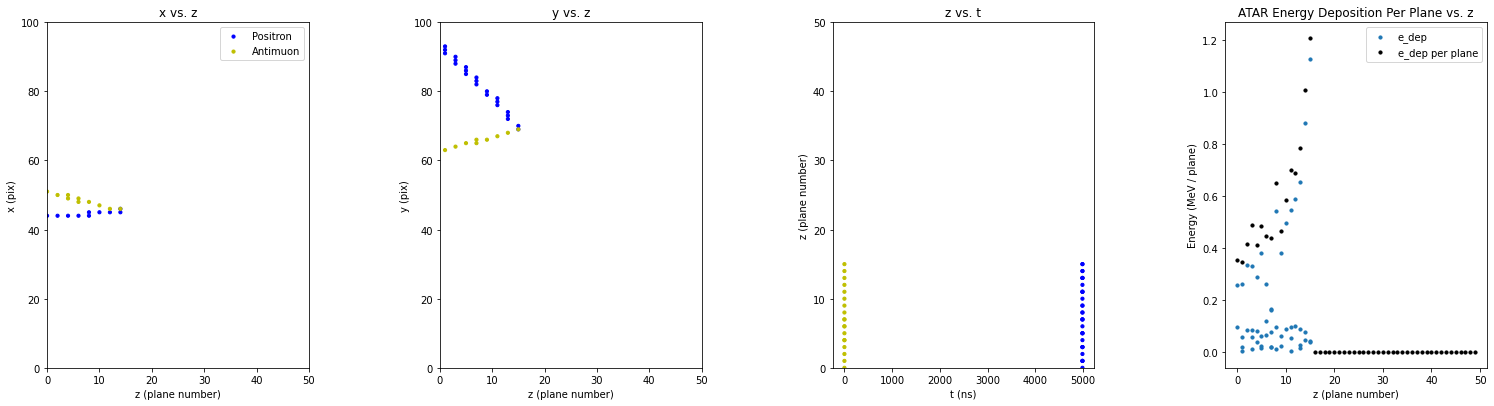

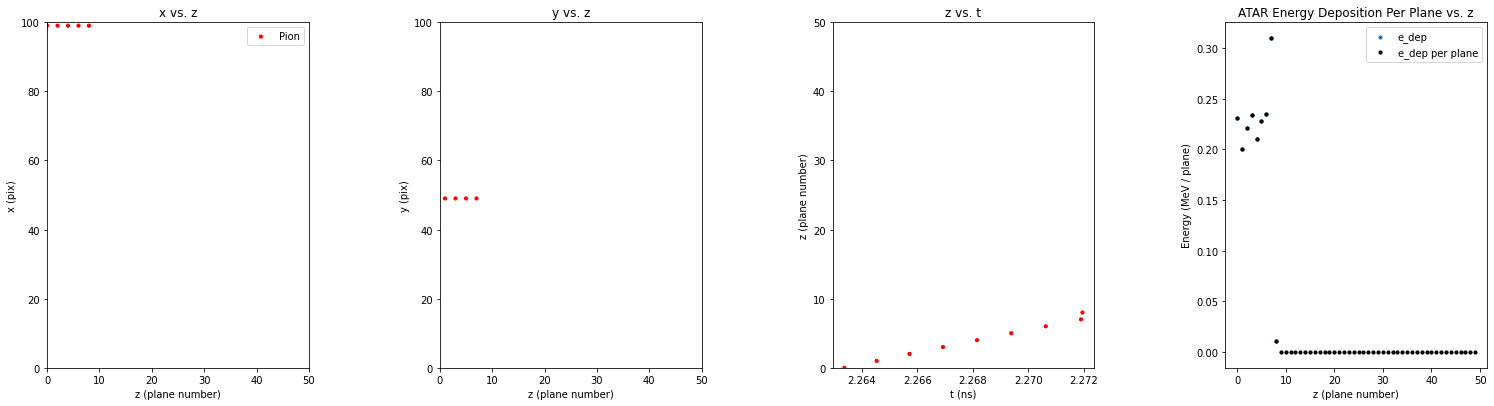

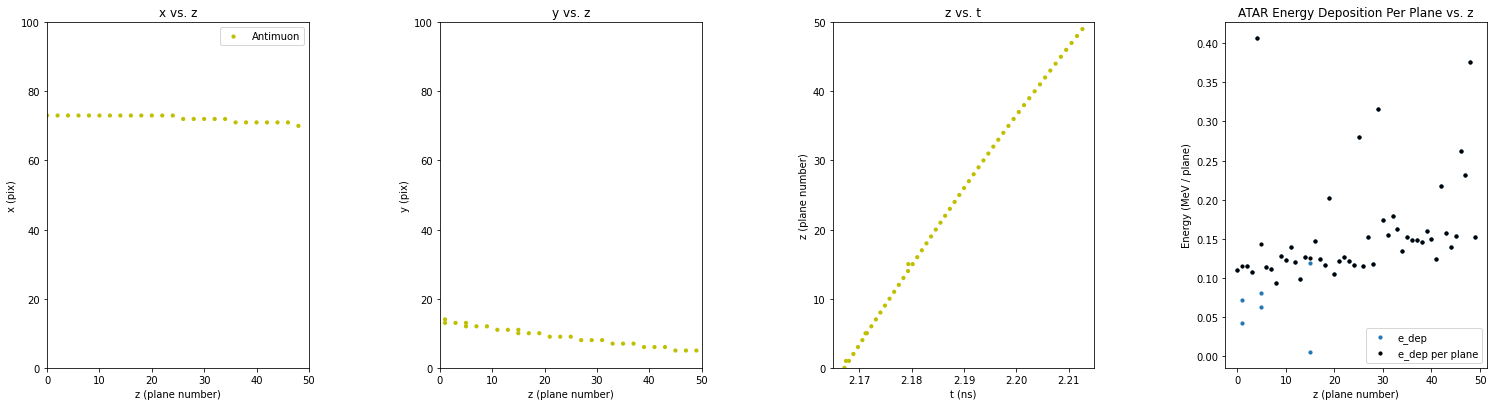

In [92]:
#Explore pion --> muon --> e data.
PiMuEfile = r.TFile("pienux_out_stripped_muons.root")
PiMuEtree = PiMuEfile.Get("atar")

max_Es = event_visualization(PiMuEtree, 0, False, True, 3)